In [1]:
import numpy as np
import pandas as pd
import pydicom
import os
import seaborn as sns
import seaborn as sb
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.preprocessing import LabelEncoder,normalize
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import category_encoders as ce
from keras.optimizers import Adam

import cv2

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-darkgrid')

In [2]:
import tensorflow as tf

# GPU device Check.
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # PyTorch use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [4]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')

In [5]:
sub = pd.read_csv("../input/osic-pulmonary-fibrosis-progression/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(test.drop('Weeks', axis=1), on="Patient")

In [6]:
sub

,Patient,Weeks,Confidence,Patient_Week,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,-12,100,ID00419637202311204720264_-12,3020,70.186855,73,Male,Ex-smoker
1,ID00419637202311204720264,-11,100,ID00419637202311204720264_-11,3020,70.186855,73,Male,Ex-smoker
2,ID00419637202311204720264,-10,100,ID00419637202311204720264_-10,3020,70.186855,73,Male,Ex-smoker
3,ID00419637202311204720264,-9,100,ID00419637202311204720264_-9,3020,70.186855,73,Male,Ex-smoker
4,ID00419637202311204720264,-8,100,ID00419637202311204720264_-8,3020,70.186855,73,Male,Ex-smoker
...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466,129,100,ID00426637202313170790466_129,2925,71.824968,73,Male,Never smoked
726,ID00426637202313170790466,130,100,ID00426637202313170790466_130,2925,71.824968,73,Male,Never smoked
727,ID00426637202313170790466,131,100,ID00426637202313170790466_131,2925,71.824968,73,Male,Never smoked
728,ID00426637202313170790466,132,100,ID00426637202313170790466_132,2925,71.824968,73,Male,Never smoked


In [7]:
train.head(100)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
95,ID00025637202179541264076,26,2880,73.193047,65,Male,Ex-smoker
96,ID00025637202179541264076,38,2811,71.439463,65,Male,Ex-smoker
97,ID00025637202179541264076,53,2533,64.374301,65,Male,Ex-smoker
98,ID00026637202179561894768,41,2884,79.571791,57,Male,Ex-smoker


FVC : forced vital capacity, i.e. the volume of air exhaled

In [8]:
test.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [9]:
print(train.shape, test.shape)

(1549, 7) (5, 7)


In [10]:
print(train.isnull().sum(),'\n')
print(test.isnull().sum())

Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64 

Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB


In [12]:
plt.figure(figsize=(16,10))

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

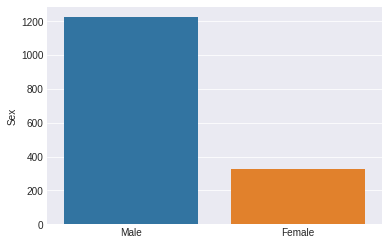

In [13]:
sns.barplot(train['Sex'].value_counts().index, train['Sex'].value_counts())

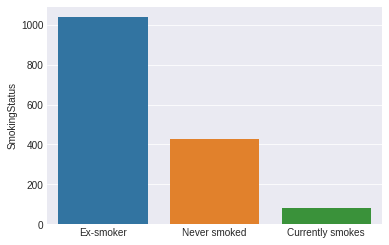

In [14]:
sns.barplot(train['SmokingStatus'].value_counts().index, train['SmokingStatus'].value_counts())

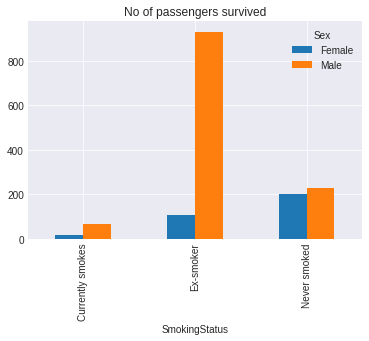

In [15]:
sa = pd.crosstab(train['SmokingStatus'],train['Sex'])
sa.plot(kind="bar",title='No of passengers survived')
plt.show()

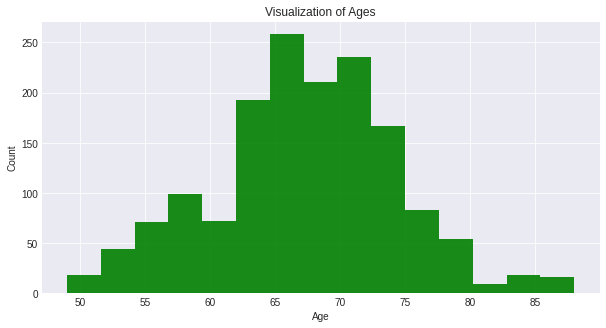

In [16]:
plt.rcParams['figure.figsize'] = 10,5
ax = train['Age'].hist(bins = 15,alpha = 0.9, color = 'green')
ax.set(xlabel = 'Age',ylabel = 'Count',title = 'Visualization of Ages')
plt.show()

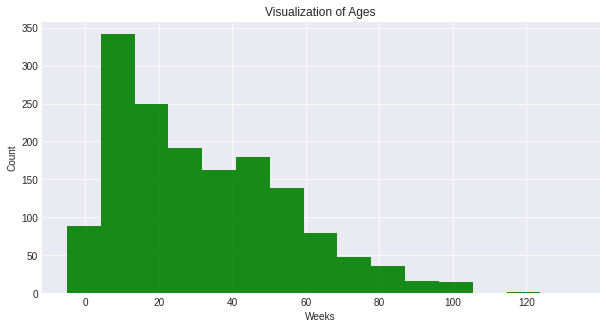

In [17]:
plt.rcParams['figure.figsize'] = 10,5
ax = train['Weeks'].hist(bins = 15,alpha = 0.9, color = 'green')
ax.set(xlabel = 'Weeks',ylabel = 'Count',title = 'Visualization of Ages')
plt.show()

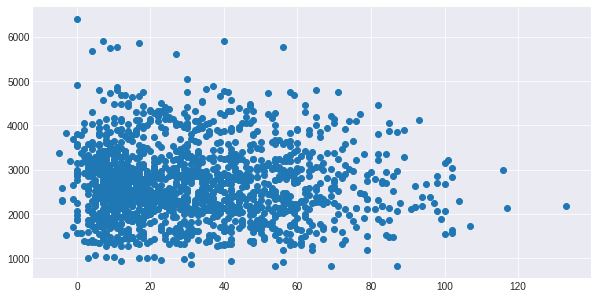

In [18]:
plt.scatter(train['Weeks'],train['FVC'])

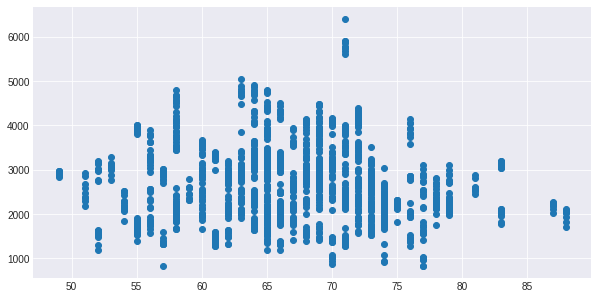

In [19]:
plt.scatter(train['Age'],train['FVC'])

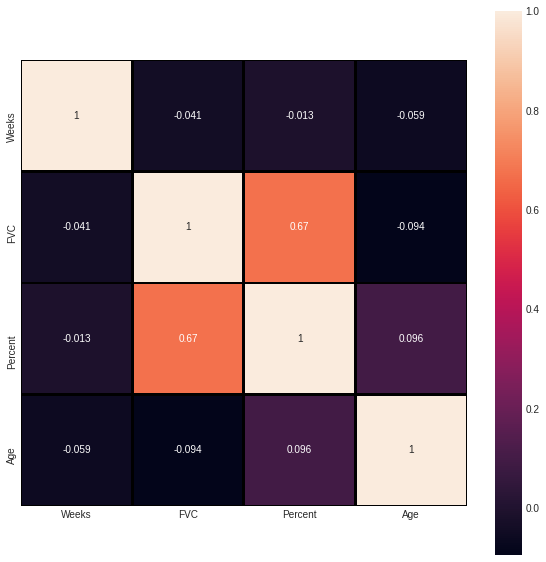

In [20]:
plt.rcParams['figure.figsize'] = 10,10
sb.heatmap(train.corr(),annot = True,square = True,linewidths = 2,linecolor = 'black')

In [21]:
train[train['FVC'] == train['FVC'].max()]

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
822,ID00219637202258203123958,0,6399,153.012912,71,Male,Ex-smoker


In [22]:
train[train['FVC'] == train['FVC'].min()]

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
864,ID00225637202259339837603,54,827,41.884021,77,Female,Never smoked


The patient of Max FVC

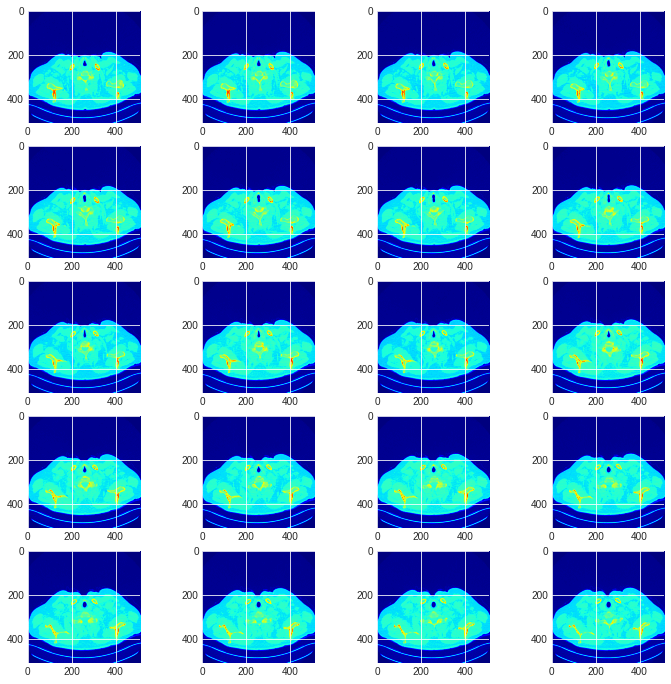

In [23]:
imdir_max = "/kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00219637202258203123958"
imdir_min = "/kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00225637202259339837603"

fig=plt.figure(figsize=(12, 12))

columns = 4
rows = 5

imglist = os.listdir(imdir_max)


for i in range(1, columns*rows +1):
    filename = imdir_max + "/" + str(i) + ".dcm"
    ds = pydicom.dcmread(filename)
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap='jet')
plt.show()

The patient of Min FVC

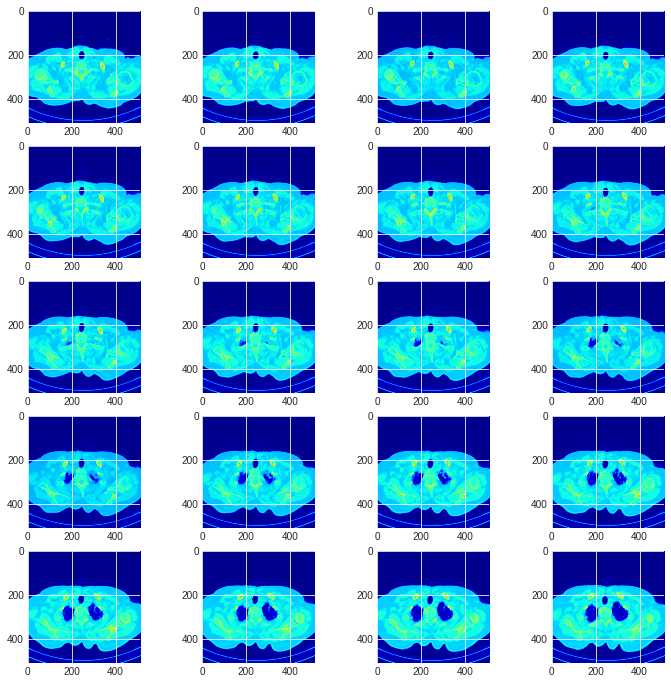

In [24]:
fig=plt.figure(figsize=(12, 12))

columns = 4
rows = 5

imglist = os.listdir(imdir_min)


for i in range(1, columns*rows +1):
    filename = imdir_min + "/" + str(i) + ".dcm"
    ds = pydicom.dcmread(filename)
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap='jet')
plt.show()

Submission File:
*     Patient_Week,FVC,Confidence
*     ID00002637202176704235138_1,2000,100
*     ID00002637202176704235138_2,2000,100
*     ID00002637202176704235138_3,2000,100

confidence = standard deviation σ

In [25]:
train['Patient_Week'] = train['Patient'].astype(str) + '_' + train['Weeks'].astype(str)
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Patient_Week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,ID00007637202177411956430_-4
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,ID00007637202177411956430_5
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,ID00007637202177411956430_7
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,ID00007637202177411956430_9
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,ID00007637202177411956430_11


In [26]:
test['Patient_Week'] = test['Patient'].astype(str) + '_' + test['Weeks'].astype(str)
test.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Patient_Week
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker,ID00419637202311204720264_6
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker,ID00421637202311550012437_15
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker,ID00422637202311677017371_6
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker,ID00423637202312137826377_17
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked,ID00426637202313170790466_0


In [27]:
print(train.shape)
print(test.shape)
train

(1549, 8)
(5, 8)


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Patient_Week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,ID00007637202177411956430_-4
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,ID00007637202177411956430_5
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,ID00007637202177411956430_7
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,ID00007637202177411956430_9
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,ID00007637202177411956430_11
...,...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked,ID00426637202313170790466_13
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked,ID00426637202313170790466_19
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked,ID00426637202313170790466_31
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked,ID00426637202313170790466_43


In [28]:
# construct train input

output = pd.DataFrame()
gb = train.groupby('Patient')
tk0 = tqdm(gb, total=len(gb))
for _, usr_df in tk0:
    usr_output = pd.DataFrame()
    for week, tmp in usr_df.groupby('Weeks'):
        rename_cols = {'Weeks': 'base_Week', 'FVC': 'base_FVC', 'Percent': 'base_Percent', 'Age': 'base_Age'}
        tmp = tmp.drop(columns='Patient_Week').rename(columns=rename_cols)
        drop_cols = ['Age', 'Sex', 'SmokingStatus', 'Percent']
        _usr_output = usr_df.drop(columns=drop_cols).rename(columns={'Weeks': 'predict_Week'}).merge(tmp, on='Patient')
        _usr_output['Week_passed'] = _usr_output['predict_Week'] - _usr_output['base_Week']
        usr_output = pd.concat([usr_output, _usr_output])
    output = pd.concat([output, usr_output])

train = output[output['Week_passed']!=0].reset_index(drop=True)

train.head()

100%|██████████| 176/176 [00:19<00:00,  8.96it/s]


,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed
0,ID00007637202177411956430,5,2214,ID00007637202177411956430_5,-4,2315,58.253649,79,Male,Ex-smoker,9
1,ID00007637202177411956430,7,2061,ID00007637202177411956430_7,-4,2315,58.253649,79,Male,Ex-smoker,11
2,ID00007637202177411956430,9,2144,ID00007637202177411956430_9,-4,2315,58.253649,79,Male,Ex-smoker,13
3,ID00007637202177411956430,11,2069,ID00007637202177411956430_11,-4,2315,58.253649,79,Male,Ex-smoker,15
4,ID00007637202177411956430,17,2101,ID00007637202177411956430_17,-4,2315,58.253649,79,Male,Ex-smoker,21


In [29]:
# construct test input

test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')\
        .rename(columns={'Weeks': 'base_Week', 'FVC': 'base_FVC', 'Percent': 'base_Percent', 'Age': 'base_Age'})
submission = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')
submission['Patient'] = submission['Patient_Week'].apply(lambda x: x.split('_')[0])
submission['predict_Week'] = submission['Patient_Week'].apply(lambda x: x.split('_')[1]).astype(int)
test = submission.drop(columns=['FVC', 'Confidence']).merge(test, on='Patient')
test['Week_passed'] = test['predict_Week'] - test['base_Week']

test.head()

,Patient_Week,Patient,predict_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,6,3020,70.186855,73,Male,Ex-smoker,-18
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,6,3020,70.186855,73,Male,Ex-smoker,-17
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,6,3020,70.186855,73,Male,Ex-smoker,-16
3,ID00419637202311204720264_-9,ID00419637202311204720264,-9,6,3020,70.186855,73,Male,Ex-smoker,-15
4,ID00419637202311204720264_-8,ID00419637202311204720264,-8,6,3020,70.186855,73,Male,Ex-smoker,-14


In [30]:
print(submission.shape)
print(test.shape)
print(train.shape)

(730, 5)
(730, 10)
(12144, 11)


In [31]:
print(train.isnull().sum(),'\n')
print(test.isnull().sum())

Patient          0
predict_Week     0
FVC              0
Patient_Week     0
base_Week        0
base_FVC         0
base_Percent     0
base_Age         0
Sex              0
SmokingStatus    0
Week_passed      0
dtype: int64 

Patient_Week     0
Patient          0
predict_Week     0
base_Week        0
base_FVC         0
base_Percent     0
base_Age         0
Sex              0
SmokingStatus    0
Week_passed      0
dtype: int64


Data Preparation

In [32]:
train.set_index(['Patient_Week'],inplace = True)

test.set_index(['Patient_Week'],inplace = True)

In [33]:
train

,Patient,predict_Week,FVC,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed
Patient_Week,,,,,,,,,,
ID00007637202177411956430_5,ID00007637202177411956430,5,2214,-4,2315,58.253649,79,Male,Ex-smoker,9
ID00007637202177411956430_7,ID00007637202177411956430,7,2061,-4,2315,58.253649,79,Male,Ex-smoker,11
ID00007637202177411956430_9,ID00007637202177411956430,9,2144,-4,2315,58.253649,79,Male,Ex-smoker,13
ID00007637202177411956430_11,ID00007637202177411956430,11,2069,-4,2315,58.253649,79,Male,Ex-smoker,15
ID00007637202177411956430_17,ID00007637202177411956430,17,2101,-4,2315,58.253649,79,Male,Ex-smoker,21
...,...,...,...,...,...,...,...,...,...,...
ID00426637202313170790466_11,ID00426637202313170790466,11,2976,59,2774,68.117081,73,Male,Never smoked,-48
ID00426637202313170790466_13,ID00426637202313170790466,13,2712,59,2774,68.117081,73,Male,Never smoked,-46
ID00426637202313170790466_19,ID00426637202313170790466,19,2978,59,2774,68.117081,73,Male,Never smoked,-40


In [34]:
y = train['FVC']
X = train.drop(['FVC'], axis=1)
X = X.drop(['Patient'], axis=1)

#y_test = test['FVC']
test_X = test.drop(['Patient'], axis=1)
#test_X = test.drop(['FVC'], axis=1)

In [35]:
X

,predict_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed
Patient_Week,,,,,,,,
ID00007637202177411956430_5,5,-4,2315,58.253649,79,Male,Ex-smoker,9
ID00007637202177411956430_7,7,-4,2315,58.253649,79,Male,Ex-smoker,11
ID00007637202177411956430_9,9,-4,2315,58.253649,79,Male,Ex-smoker,13
ID00007637202177411956430_11,11,-4,2315,58.253649,79,Male,Ex-smoker,15
ID00007637202177411956430_17,17,-4,2315,58.253649,79,Male,Ex-smoker,21
...,...,...,...,...,...,...,...,...
ID00426637202313170790466_11,11,59,2774,68.117081,73,Male,Never smoked,-48
ID00426637202313170790466_13,13,59,2774,68.117081,73,Male,Never smoked,-46
ID00426637202313170790466_19,19,59,2774,68.117081,73,Male,Never smoked,-40


In [36]:
# getting dummy variables column

enc = LabelEncoder()

X['Sex'] = enc.fit_transform(X['Sex'])

X['SmokingStatus'] = enc.fit_transform(X['SmokingStatus'])

In [37]:
X

,predict_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed
Patient_Week,,,,,,,,
ID00007637202177411956430_5,5,-4,2315,58.253649,79,1,1,9
ID00007637202177411956430_7,7,-4,2315,58.253649,79,1,1,11
ID00007637202177411956430_9,9,-4,2315,58.253649,79,1,1,13
ID00007637202177411956430_11,11,-4,2315,58.253649,79,1,1,15
ID00007637202177411956430_17,17,-4,2315,58.253649,79,1,1,21
...,...,...,...,...,...,...,...,...
ID00426637202313170790466_11,11,59,2774,68.117081,73,1,2,-48
ID00426637202313170790466_13,13,59,2774,68.117081,73,1,2,-46
ID00426637202313170790466_19,19,59,2774,68.117081,73,1,2,-40


In [38]:
test_X['Sex'] = enc.fit_transform(test_X['Sex'])
test_X['SmokingStatus'] = enc.fit_transform(test_X['SmokingStatus'])

In [39]:
test_X

,predict_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed
Patient_Week,,,,,,,,
ID00419637202311204720264_-12,-12,6,3020,70.186855,73,0,0,-18
ID00419637202311204720264_-11,-11,6,3020,70.186855,73,0,0,-17
ID00419637202311204720264_-10,-10,6,3020,70.186855,73,0,0,-16
ID00419637202311204720264_-9,-9,6,3020,70.186855,73,0,0,-15
ID00419637202311204720264_-8,-8,6,3020,70.186855,73,0,0,-14
...,...,...,...,...,...,...,...,...
ID00426637202313170790466_129,129,0,2925,71.824968,73,0,1,129
ID00426637202313170790466_130,130,0,2925,71.824968,73,0,1,130
ID00426637202313170790466_131,131,0,2925,71.824968,73,0,1,131


In [40]:
y

Patient_Week
ID00007637202177411956430_5     2214
ID00007637202177411956430_7     2061
ID00007637202177411956430_9     2144
ID00007637202177411956430_11    2069
ID00007637202177411956430_17    2101
                                ... 
ID00426637202313170790466_11    2976
ID00426637202313170790466_13    2712
ID00426637202313170790466_19    2978
ID00426637202313170790466_31    2908
ID00426637202313170790466_43    2975
Name: FVC, Length: 12144, dtype: int64

In [41]:
#Normalizing

from sklearn.preprocessing import normalize

X = normalize(X)

Modeling

In [42]:
sub = test_X 
pe = np.zeros((test_X.shape[0], 3)) #for predict test
pred = np.zeros((X.shape[0], 3)) #for predict val
ze = sub

In [43]:
# convert df to array

#X = X.to_numpy()

In [44]:
ze

,predict_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed
Patient_Week,,,,,,,,
ID00419637202311204720264_-12,-12,6,3020,70.186855,73,0,0,-18
ID00419637202311204720264_-11,-11,6,3020,70.186855,73,0,0,-17
ID00419637202311204720264_-10,-10,6,3020,70.186855,73,0,0,-16
ID00419637202311204720264_-9,-9,6,3020,70.186855,73,0,0,-15
ID00419637202311204720264_-8,-8,6,3020,70.186855,73,0,0,-14
...,...,...,...,...,...,...,...,...
ID00426637202313170790466_129,129,0,2925,71.824968,73,0,1,129
ID00426637202313170790466_130,130,0,2925,71.824968,73,0,1,130
ID00426637202313170790466_131,131,0,2925,71.824968,73,0,1,131


In [45]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

# C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
# #=============================#
# def score(y_true, y_pred):
#     tf.dtypes.cast(y_true, tf.float32)
#     tf.dtypes.cast(y_pred, tf.float32)
#     sigma = y_pred[:, 2] - y_pred[:, 0]
#     fvc_pred = y_pred[:, 1]
    
#     #sigma_clip = sigma + C1
#     sigma_clip = tf.maximum(sigma, C1)
#     delta = tf.abs(y_true[:, 0] - fvc_pred)
#     delta = tf.minimum(delta, C2)
#     sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
#     metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
#     return K.mean(metric)
# #============================#
# def qloss(y_true, y_pred):
#     # Pinball loss for multiple quantiles
#     qs = [0.2, 0.50, 0.8]
#     q = tf.constant(np.array([qs]), dtype=tf.float32)
#     e = y_true - y_pred
#     v = tf.maximum(q*e, (q-1)*e)
#     return K.mean(v)
# #=============================#
# def mloss(_lambda):
#     def loss(y_true, y_pred):
#         return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
#     return loss
# #=================
def make_model():
    z = L.Input((8,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
   # x = L.Dense(100, activation="relu", name="d3")(x)
   # x = L.Dense(100, activation="relu", name="d4")(x)
    p1 = L.Dense(3, activation="relu", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    #model.compile(loss=qloss, optimizer="adam", metrics=[score])
    opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01, amsgrad=False)
    model.compile(loss = 'binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [46]:
net = make_model()
net.summary()

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Patient (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
d1 (Dense)                      (None, 100)          900         Patient[0][0]                    
__________________________________________________________________________________________________
d2 (Dense)                      (None, 100)          10100       d1[0][0]                         
__________________________________________________________________________________________________
p1 (Dense)                      (None, 3)            303         d2[0][0]                         
________________________________________________________________________________________________

In [47]:
from sklearn.svm import SVR
from sklearn.model_selection import KFold

scores = []

NFOLD = 50
kf = KFold(n_splits=NFOLD)
BATCH_SIZE = 128

In [48]:
%%time
cnt = 0
for tr_idx, val_idx in kf.split(X):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model()
    net.fit(X[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=400, 
            validation_data=(X[val_idx], y[val_idx]), verbose=0) #
    print("train", net.evaluate(X[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(X[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")
    pred[val_idx] = net.predict(X[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD

FOLD 1
train [-41174.6953125, 0.0]
val [-45248.06640625, 0.0]
predict val...
predict test...
FOLD 2
train [-41072.55859375, 0.0]
val [-50250.31640625, 0.0]
predict val...
predict test...
FOLD 3
train [-41486.3359375, 0.0]
val [-29985.650390625, 0.0]
predict val...
predict test...
FOLD 4
train [-41243.61328125, 0.0]
val [-41872.8984375, 0.0]
predict val...
predict test...
FOLD 5
train [-40954.52734375, 0.0]
val [-56031.09375, 0.0]
predict val...
predict test...
FOLD 6
train [-41404.51171875, 0.0]
val [-33992.75, 0.0]
predict val...
predict test...
FOLD 7
train [-41097.29296875, 0.0]
val [-46420.49609375, 0.0]
predict val...
predict test...
FOLD 8
train [-41279.25390625, 0.0]
val [-40127.20703125, 0.0]
predict val...
predict test...
FOLD 9
train [-13622.0751953125, 0.0]
val [-11942.458984375, 0.0]
predict val...
predict test...
FOLD 10
train [-41263.34765625, 0.0]
val [-40906.4296875, 0.0]
predict val...
predict test...
FOLD 11
train [-40967.38671875, 0.0]
val [-55401.234375, 0.0]
predic

In [49]:
from sklearn.metrics import mean_absolute_error
 
sigma_opt = mean_absolute_error(y, pred[:, 1]) 
unc = pred[:,2] - pred[:, 0] 
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

2705.320038584116 0.3703205159365915


In [50]:
print(pred.shape)
print(pred)

(12144, 3)
[[1.15241909 1.01546597 1.78730369]
 [1.1525774  1.01550794 1.7874006 ]
 [1.1527344  1.01554871 1.78749561]
 ...
 [1.10995364 1.03856015 1.66057241]
 [1.11105108 1.03936577 1.66137385]
 [1.11211443 1.04013968 1.66212368]]


In [51]:
print(pe.shape)

(730, 3)


In [52]:
test

,Patient,predict_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed
Patient_Week,,,,,,,,,
ID00419637202311204720264_-12,ID00419637202311204720264,-12,6,3020,70.186855,73,Male,Ex-smoker,-18
ID00419637202311204720264_-11,ID00419637202311204720264,-11,6,3020,70.186855,73,Male,Ex-smoker,-17
ID00419637202311204720264_-10,ID00419637202311204720264,-10,6,3020,70.186855,73,Male,Ex-smoker,-16
ID00419637202311204720264_-9,ID00419637202311204720264,-9,6,3020,70.186855,73,Male,Ex-smoker,-15
ID00419637202311204720264_-8,ID00419637202311204720264,-8,6,3020,70.186855,73,Male,Ex-smoker,-14
...,...,...,...,...,...,...,...,...,...
ID00426637202313170790466_129,ID00426637202313170790466,129,0,2925,71.824968,73,Male,Never smoked,129
ID00426637202313170790466_130,ID00426637202313170790466,130,0,2925,71.824968,73,Male,Never smoked,130
ID00426637202313170790466_131,ID00426637202313170790466,131,0,2925,71.824968,73,Male,Never smoked,131


![](https://i.imgur.com/EV7xPrl.png)

In [53]:
sub

,predict_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed
Patient_Week,,,,,,,,
ID00419637202311204720264_-12,-12,6,3020,70.186855,73,0,0,-18
ID00419637202311204720264_-11,-11,6,3020,70.186855,73,0,0,-17
ID00419637202311204720264_-10,-10,6,3020,70.186855,73,0,0,-16
ID00419637202311204720264_-9,-9,6,3020,70.186855,73,0,0,-15
ID00419637202311204720264_-8,-8,6,3020,70.186855,73,0,0,-14
...,...,...,...,...,...,...,...,...
ID00426637202313170790466_129,129,0,2925,71.824968,73,0,1,129
ID00426637202313170790466_130,130,0,2925,71.824968,73,0,1,130
ID00426637202313170790466_131,131,0,2925,71.824968,73,0,1,131


In [54]:
import math

#calcule Confidence

sub['FVC'] = test['base_FVC'] 
sub['FVC_pred'] = pe[:, 1]

# baseline score
sub['Confidence'] = 100
sub['sigma_clipped'] = sub['Confidence'].apply(lambda x: max(x, 70))
sub['diff'] = abs(sub['FVC'] - sub['FVC_pred'])
sub['delta'] = sub['diff'].apply(lambda x: min(x, 1000))
sub['score'] = -math.sqrt(2)*sub['delta']/sub['sigma_clipped'] - np.log(math.sqrt(2)*sub['sigma_clipped'])
score = sub['score'].mean()
print(score)

-8.915595011957615


In [55]:
import scipy as sp
from functools import partial

def loss_func(weight, row):
    confidence = weight
    sigma_clipped = max(confidence, 70)
    diff = abs(row['FVC'] - row['FVC_pred'])
    delta = min(diff, 1000)
    score = -math.sqrt(2)*delta/sigma_clipped - np.log(math.sqrt(2)*sigma_clipped)
    return -score

results = []
tk0 = tqdm(sub.iterrows(), total=len(sub))
for _, row in tk0:
    loss_partial = partial(loss_func, row=row)
    weight = [100]
    #bounds = [(70, 100)]
    #result = sp.optimize.minimize(loss_partial, weight, method='SLSQP', bounds=bounds)
    result = sp.optimize.minimize(loss_partial, weight, method='SLSQP')
    x = result['x']
    results.append(x[0])

100%|██████████| 730/730 [00:03<00:00, 239.52it/s]


In [56]:
# optimized score
sub['Confidence'] = results
sub['sigma_clipped'] = sub['Confidence'].apply(lambda x: max(x, 70))
sub['diff'] = abs(sub['FVC'] - sub['FVC_pred'])
sub['delta'] = sub['diff'].apply(lambda x: min(x, 1000))
sub['score'] = -math.sqrt(2)*sub['delta']/sub['sigma_clipped'] - np.log(math.sqrt(2)*sub['sigma_clipped'])
score = sub['score'].mean()
print(score)

-7.309859498475791


In [57]:
sub

,predict_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,FVC,FVC_pred,Confidence,sigma_clipped,diff,delta,score
Patient_Week,,,,,,,,,,,,,,,
ID00419637202311204720264_-12,-12,6,3020,70.186855,73,0,0,-18,3020,2708.584816,440.248999,440.248999,311.415184,311.415184,-7.434274
ID00419637202311204720264_-11,-11,6,3020,70.186855,73,0,0,-17,3020,2708.660347,440.158117,440.158117,311.339653,311.339653,-7.434032
ID00419637202311204720264_-10,-10,6,3020,70.186855,73,0,0,-16,3020,2708.735588,440.056954,440.056954,311.264412,311.264412,-7.433790
ID00419637202311204720264_-9,-9,6,3020,70.186855,73,0,0,-15,3020,2708.810944,439.947201,439.947201,311.189056,311.189056,-7.433548
ID00419637202311204720264_-8,-8,6,3020,70.186855,73,0,0,-14,3020,2708.886211,439.826586,439.826586,311.113789,311.113789,-7.433306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID00426637202313170790466_129,129,0,2925,71.824968,73,0,1,129,2925,2628.102165,419.794392,419.794392,296.897835,296.897835,-7.386535
ID00426637202313170790466_130,130,0,2925,71.824968,73,0,1,130,2925,2628.111763,419.797573,419.797573,296.888237,296.888237,-7.386503
ID00426637202313170790466_131,131,0,2925,71.824968,73,0,1,131,2925,2628.121391,419.759709,419.759709,296.878609,296.878609,-7.386471


In [58]:
sub.reset_index(inplace=True) #for Patient_Week
sub =  sub[['Patient_Week', 'FVC_pred', 'Confidence']].copy()
sub

,Patient_Week,FVC_pred,Confidence
0,ID00419637202311204720264_-12,2708.584816,440.248999
1,ID00419637202311204720264_-11,2708.660347,440.158117
2,ID00419637202311204720264_-10,2708.735588,440.056954
3,ID00419637202311204720264_-9,2708.810944,439.947201
4,ID00419637202311204720264_-8,2708.886211,439.826586
...,...,...,...
725,ID00426637202313170790466_129,2628.102165,419.794392
726,ID00426637202313170790466_130,2628.111763,419.797573
727,ID00426637202313170790466_131,2628.121391,419.759709
728,ID00426637202313170790466_132,2628.130894,419.747407


In [59]:
sub = sub.rename(columns={"FVC_pred": "FVC"})
sub.to_csv('submission.csv', index=False)
sub.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2708.584816,440.248999
1,ID00419637202311204720264_-11,2708.660347,440.158117
2,ID00419637202311204720264_-10,2708.735588,440.056954
3,ID00419637202311204720264_-9,2708.810944,439.947201
4,ID00419637202311204720264_-8,2708.886211,439.826586
